In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import random
import itertools
from torchvision import datasets, transforms, models
from collections import OrderedDict
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tqdm import tqdm , trange
from tqdm import tnrange


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.set_device(1)
torch.__version__

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


#Check GPU support, please do activate GPU
print(torch.cuda.current_device())
print(torch.cuda.is_available())
torch.cuda.get_device_name(torch.cuda.current_device())

Using device: cuda
NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
1
True


'NVIDIA GeForce GTX 1080 Ti'

In [3]:
def read_alphabets(class_directory_path, class_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    images = os.listdir(class_directory_path + '/')
    for img in images:
        image=cv2.imread(class_directory_path + '/' + img)
        image=cv2.resize(image,(224,224))
        image = image[:,:,::-1]
        datax.append(image)
        datay.append(class_directory_name+"")
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [read_alphabets(base_directory + '/' + directory + '/',directory) for directory in os.listdir(base_directory)]
    pool.close()
    for result in tqdm(results):
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

### Data

The Onion dataset is divided into 2 groups of 4 classes each depending on the number of images available.

1st Group: 'Basal rot', 'Bulb rot seed crop', 'Damping off disease', 'Healthy'

- Considerable number of images in the dataset (>100)


2nd Group: Anthracnose disease, Iris yelloe spot virus, Purple blotch disease, Stemphylium blight disease

- Less number of images for each class (<50)


The multi/val and multi/train paths contain only images for each class from the 1st group split into a 30:70 ratio. Whereas the multi/test split contain images for each class from the 2nd group.

In [4]:
%%time 
trainx, trainy = read_images('/home/SharedData/Siddharth/selective_dataset/multi/train')
valx, valy = read_images('/home/SharedData/Siddharth/selective_dataset/multi/val')
testx, testy = read_images('/home/SharedData/Siddharth/selective_dataset/multi/test')
print(trainx.shape)
print(valx.shape)
print(testx.shape)

100%|██████████| 4/4 [00:00<00:00, 361.53it/s]
Premature end of JPEG file
Premature end of JPEG file
100%|██████████| 4/4 [00:00<00:00, 1620.05it/s]

(421, 224, 224, 3)
(194, 224, 224, 3)
(76, 224, 224, 3)
CPU times: user 2min 8s, sys: 8.2 s, total: 2min 16s
Wall time: 2min 16s


In [5]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    #print(datay.shape)
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample.append(sample_cls)
    sample = np.array(sample,dtype=object)
    sample = sample.astype(np.uint8)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0,1,4,2,3)
    #print(sample.size())
    return({
            'images': sample,
            'n_way': n_way,
            'n_support': n_support,
            'n_query': n_query
        })

In [6]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  out=out.permute(1,2,0)
  plt.imshow(out.int())

Bulb rot seed crop


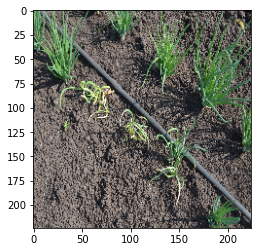

In [7]:
plt.imshow(trainx[100])
print(trainy[100])
plt.show()

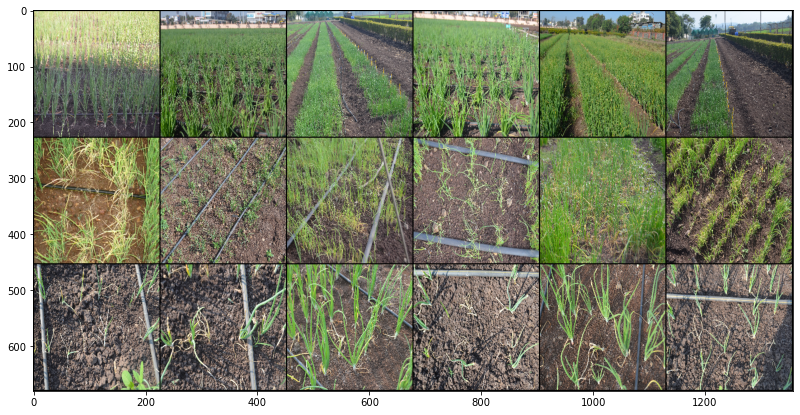

In [8]:
sample_example = extract_sample(3, 1, 5, trainx, trainy)
display_sample(sample_example['images'])

In [9]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [10]:
def set_forward_loss(model, sample):
  """
  Computes loss, accuracy and output for classification task
  Args:
      sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
  Returns:
      torch.Tensor: shape(2), loss, accuracy and y_hat
  """
  sample_images = sample['images'].cuda()
  n_way = sample['n_way']
  n_support = sample['n_support']
  n_query = sample['n_query']

  x_support = sample_images[:, :n_support]
  x_query = sample_images[:, n_support:]
  #target indices are 0 ... n_way-1
  target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
  target_inds = Variable(target_inds, requires_grad=False)
  target_inds = target_inds.cuda()
  #encode images of the support and the query set
  x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                  x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
  
  z = model(x)
  z_dim = z.size(-1) #usually 64
  z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
  z_query = z[n_way*n_support:]

  #compute distances
  dists = euclidean_dist(z_query, z_proto)
  #compute probabilities
  log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
  loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
  _, y_hat = log_p_y.max(2)
  acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
  return loss_val, {
      'loss': loss_val.item(),
      'acc': acc_val.item(),
      'y_hat': y_hat
      }

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
# Number of classes in the dataset
num_classes = 39

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [13]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

In [14]:
def final_classifier(num_ftrs,num_classes):
  return nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet18
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        print(num_ftrs)
        model_ft.classifier[6] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        print(num_ftrs)
        model_ft.classifier[6] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = 512
        print(num_ftrs)
        model_ft.classifier[1] = final_classifier(num_ftrs,num_classes)
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        print(num_ftrs)
        model_ft.classifier = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        print(num_ftrs)
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [15]:
model_to_load = 'densenet'
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location='cuda:0')
    model,initial_size = initialize_model(model_to_load,num_classes,feature_extract,use_pretrained=True)
    
    model.load_state_dict(checkpoint)
    model.to(device)
    
    return model, checkpoint

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/home/SharedData/Siddharth/models/plantvillage_full_'+model_to_load+'.pt')

1024


In [16]:
loaded_model = loaded_model.features

In [17]:
# Flattening the final output to create an embedding
loaded_model = nn.Sequential(
        loaded_model,
        Flatten()
        )

In [20]:
print(loaded_model)

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): R

In [21]:
val_loss=[]
import copy
import time

In [22]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = set_forward_loss(model,sample)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    val_loss.append(avg_loss)
    if ( best_acc <= avg_acc):
        best_acc = avg_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    return best_model_wts

In [23]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far
    stop = False #status to know when to stop
    loss_arr=[]
    since = time.time()
    
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0
        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = set_forward_loss(model,sample)
            instant_loss=output['loss']
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        loss_arr.append(epoch_loss)
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        with torch.no_grad():
            best_model_wts = test(model,valx,valy,n_way,n_support,n_query,epoch_size)
        epoch += 1
        scheduler.step()
    epoch_arr=np.linspace(1,max_epoch,max_epoch)
    plt.plot(epoch_arr,loss_arr)
    plt.plot(epoch_arr,val_loss)
    plt.show()

In [ ]:
model = loaded_model

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 4
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 500

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        print(name)
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size) 

model.load_state_dict(best_model_wts)

## Save Model

In [47]:
torch.save(model.state_dict(),"/home/SharedData/Siddharth/models/onion_protonet_finetuned.pth")

## Load model

In [ ]:
def load_protonet_model(model,filepath):
    checkpoint = torch.load(filepath,map_location='cuda:0')
    
    model.load_state_dict(checkpoint)
    model.to(device)
    
    return model, checkpoint

model = load_protonet_model(loaded_model,'/home/SharedData/Siddharth/models/onion_protonet_finetuned.pth')

## Testing

In [ ]:
with torch.no_grad():
    n_way = 4
    n_support = 4
    n_query = 1

    test_episode = 500

    test(model, testx,testy, n_way, n_support, n_query, test_episode)

In [ ]:
my_sample = extract_sample(8, 5, 5,clean_testx, clean_testy)
display_sample(my_sample['images'])